#Praktikum 1
RNN untuk Analisis Sentimen
##Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [8]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label)

In [9]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Whale-hunters pick on the wrong freaking whale.<br /><br />A group of yahoo whale exploitists capture a female and string her up by her tail-fin. The whale\'s mate sees the whole thing including the moment the female\'s unborn baby slips out and slops onto the deck. \'Captain Nolan\' (Richard Harris) could tell that the big male is really mad by the way it stared him down as if to say, "Get out of town before high-tide." <br /><br />This story of revenge has Harris\' presence and Bo\'s beauty, but not much else. This was Bo\'s first \'released\' film, though her first acting job was four years previous in \'And Once Upon a Love\' released in 1981 as \'Fantasies\' (directed by John Derek).<br /><br />P.S. Today, the date of this review (November 20), is Bo Derek\'s birthday. I hope Bo has a \'whale\' of a good time..... get it?..... whale?..... hee-hee.'
 b'I approach films about talking animals with care. For every wonderful one like Babe, you get an equally poor one like th

#Buat Teks Encoder
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,  10, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  9,  44, 291, ..., 133,   5,   1]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

* Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
* Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Spoilers Following: I picked up the book "Evil Angels" when it first came out knowing nothing of the case. Just to give the press and the Austrialian people a break here, I was quite far into it before I began to question the Chamberlain\'s guilt. The author obviously intended the reader to understand why the public jumped to the conclusions they did. John Bryson told the story just as it was presented to the jurors (and picked up by the press) of the arterial spray, the actelone (??) plates, Dr. James Cameron\'s certainty that the collar was cut with scissors, that a baby could not be taken whole from her clothes with the buttons still done up, bloody hand print, etc. all quite convincingly. After all, these were experts in their fields who were testifying with no apparent reason to lie, and the fact that the evidence was completely wrong wasn\'t apparent to me at all. It was also highly technical evidence, difficult for a layman to understand. To this point, beyond some 

#Buat Model

In [11]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
for i, layer in enumerate(model.layers):
    print(f"Lapisan {i}: {layer}")

Lapisan 0: <keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b56f04adb40>
Lapisan 1: <keras.src.layers.core.embedding.Embedding object at 0x7b56ebf2c0d0>
Lapisan 2: <keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b56ebf2f400>
Lapisan 3: <keras.src.layers.core.dense.Dense object at 0x7b56ebf2d8a0>
Lapisan 4: <keras.src.layers.core.dense.Dense object at 0x7b56ebf2d6f0>


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00034478]


In [15]:
  # predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 490ms/step
[0.00034478]


  compile model Keras untuk mengonfigurasi proses pelatihan:

In [16]:

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Train Model

In [17]:

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 728s 2s/step - loss: 0.6420 - accuracy: 0.5723 - val_loss: 0.5072 - val_accuracy: 0.7479
Epoch 2/10
391/391 [==============================] - 705s 2s/step - loss: 0.4188 - accuracy: 0.8157 - val_loss: 0.3729 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 708s 2s/step - loss: 0.3475 - accuracy: 0.8471 - val_loss: 0.3422 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 711s 2s/step - loss: 0.3229 - accuracy: 0.8610 - val_loss: 0.3515 - val_accuracy: 0.8286
Epoch 5/10
391/391 [==============================] - 719s 2s/step - loss: 0.3128 - accuracy: 0.8666 - val_loss: 0.3322 - val_accuracy: 0.8448
Epoch 6/10
391/391 [==============================] - 744s 2s/step - loss: 0.3067 - accuracy: 0.8680 - val_loss: 0.3284 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 760s 2s/step - loss: 0.3022 - accuracy: 0.8719 - val_loss: 0.3276 - val_accuracy: 0.8547

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 169s 432ms/step - loss: 0.3219 - accuracy: 0.8616
Test Loss: 0.32192936539649963
Test Accuracy: 0.8615599870681763


(0.0, 0.6593550413846969)

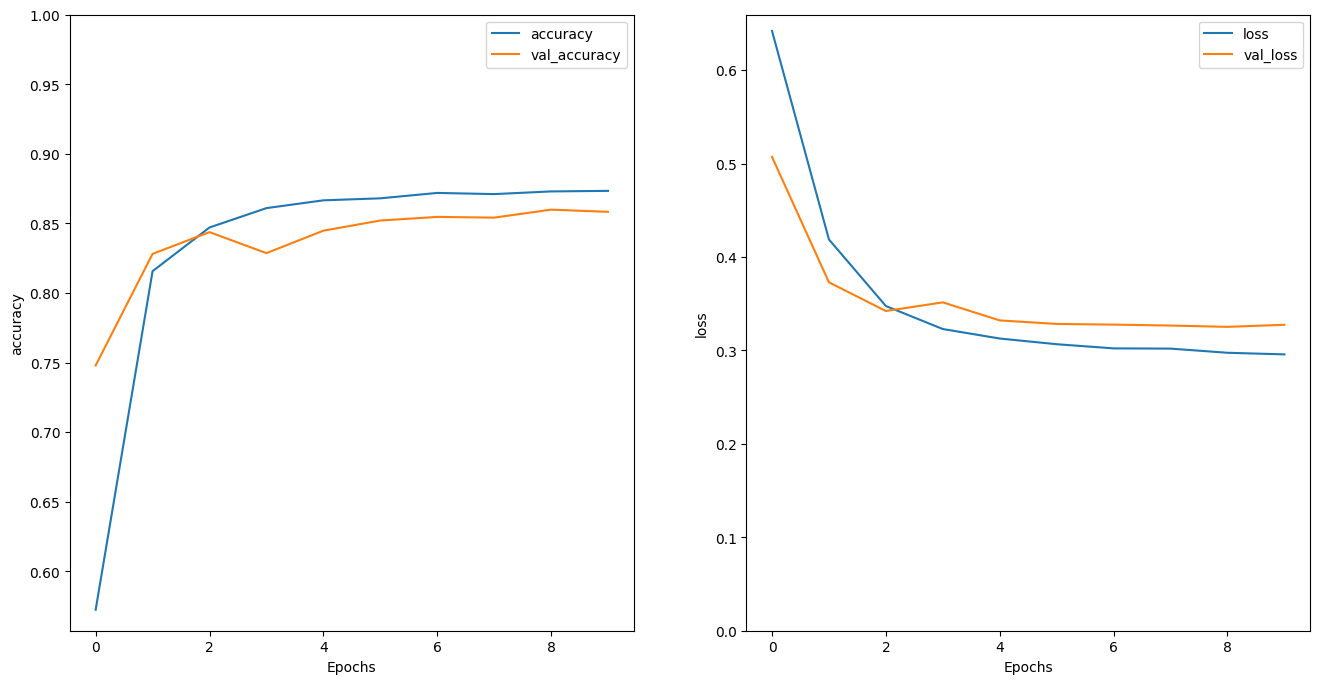

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.8477481]


#Stack two or more LSTM layers
Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1190s 3s/step - loss: 0.6059 - accuracy: 0.6126 - val_loss: 0.4177 - val_accuracy: 0.8250
Epoch 2/10
391/391 [==============================] - 1152s 3s/step - loss: 0.3704 - accuracy: 0.8384 - val_loss: 0.3453 - val_accuracy: 0.8521
Epoch 3/10
391/391 [==============================] - 1155s 3s/step - loss: 0.3308 - accuracy: 0.8574 - val_loss: 0.3252 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 1145s 3s/step - loss: 0.3152 - accuracy: 0.8652 - val_loss: 0.3210 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 1148s 3s/step - loss: 0.3078 - accuracy: 0.8680 - val_loss: 0.3253 - val_accuracy: 0.8453
Epoch 6/10
391/391 [==============================] - 1155s 3s/step - loss: 0.3028 - accuracy: 0.8689 - val_loss: 0.3202 - val_accuracy: 0.8516
Epoch 7/10
391/391 [==============================] - 1188s 3s/step - loss: 0.3021 - accuracy: 0.8696 - val_loss: 0.3206 - val_accuracy:

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 265s 678ms/step - loss: 0.3165 - accuracy: 0.8598
Test Loss: 0.31645438075065613
Test Accuracy: 0.8598399758338928


In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.2354987]]


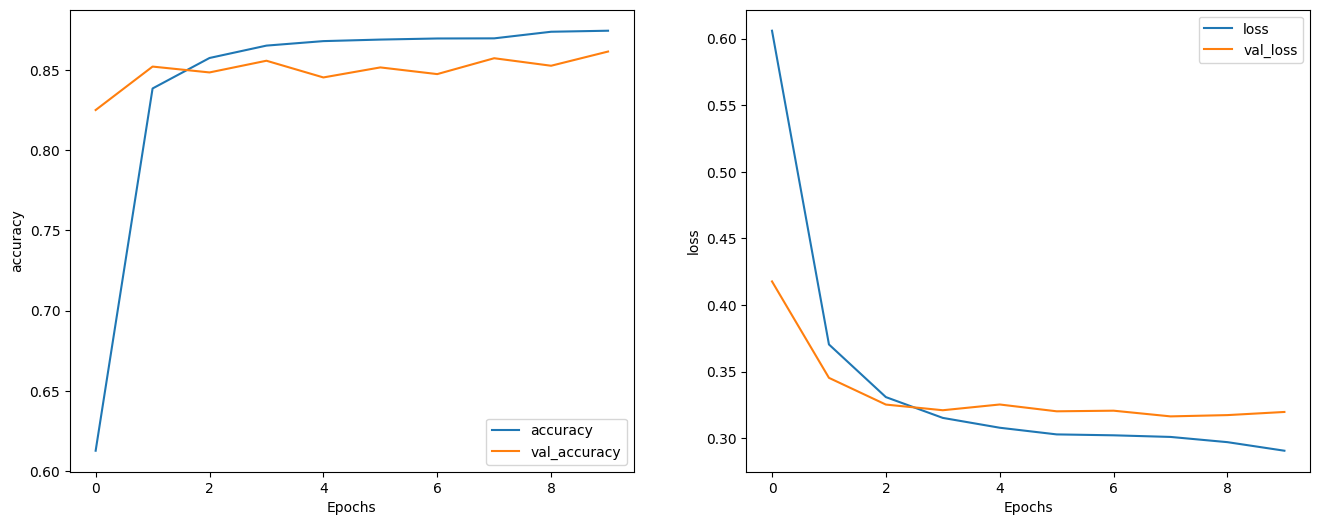

In [18]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')